<a href="https://colab.research.google.com/github/ms337/vpc-exp/blob/master/VPC_exp_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Implementation ported from MATLAB



## Package Imports to Support Functionality

In [ ]:
import matplotlib.pyplot as plt #for plotting graphs and functions
from scipy.optimize import curve_fit #for curve fitting see https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
import pandas as pd #for importing data from excel
import numpy as np #To support vectorized operations: each vector is treat as a numpy array 
import scipy.integrate as integrate #integrating function
from math import exp, log10, sinh #basic math functions
!pip install lmfit
from lmfit import Model #Secondt curve fitting tool
import csv #to output data in comma separated value format

## Setup

The following section reads in the data from the Excel file. 

The data is stored in variables as follows:

x : stores the X data col
y : stores y data col
sigma: stores Error col
weights: stores Weight column

All these variables are vectors, i.e. numpy arrays
Thus all operations on them will be automatically vectorized (mostly).


In [ ]:
data = pd.read_excel('./data_to_fit.xlsx')
x = np.array(data['X'])
y = np.array(data['Y'])
sigma = np.array(data['Error'])
weights = np.array(data['Weight'])

### Helper Functions

I have defined some custom functions to use them on them fly to help plot and analyze the data.

In [ ]:
#Use this whenever you want to print the data points, will need to call this before you plot the
#function obtained after fitting so see it overlay on the data points.
def print_data():
    plt.plot(x, y, 'o', label='data')

In [ ]:
def r_square(y, y_hat):
    ss_res = np.sum((y - y_hat) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [ ]:
def chisq(y, y_hat, uncertainity):
    return np.sum( (y - y_hat)**2 / uncertainity**2 )

## Equations

1. VPCexp returns the vectorized y vector.
2. final_eq is the function which is to be fitted.

In [ ]:
def VPCexp(z, Om0, R0, a):
    n = len(z)
    y = np.zeros(n)
    
    errors =[0]*n

    for i in range(0, n): #vectors/arrays in python start from index 0 rather than 1 as in MATLAB
        zl = z[i]
        #anonymous function
        fun= lambda x: (Om0*(((1+x)**3)*exp((a/3)*(1-(1+x)**(-3)))-(exp(((2*a)/3)*(1-(1+x)**(-3))))+((1+x)**2)))**-0.5
        result= integrate.quad(fun, 0, zl) # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html
        yl = result[0]
        dP=R0*sinh(yl/exp((-a/3)*(1-((1+zl)**(-3)))))
        y[i] = 5*log10(dP) 
    return y #returns the vectorized y

def final_eq(z, Om0, R0, a):
    return VPCexp(z, Om0, R0, a) + 5*np.log10((1+z)) + 25 #also returns vectorized output





## Tool 1:  Using Scipy (Recommeded)

### Defining initial params
Change the values in the first 3 lines to change the initial params passed to the curve_fitting tool

In [ ]:
Om0_param = 0.5 #range =0-3
R0_param = float(299840/70)  #range=3000-5000
a_param = 0.8 #range=0-3
init_vals = [Om0_param, R0_param, a_param] #initial_params array will be passed to the curve fitting tool

## Curve Fitting
This is the part when the curve is fit to the data.

We use the curve_fit function. See documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

1. sigma: the vector of uncertainities (our Error column)
2. bounds: tuple defined as  ((lower bound for each parameter), (upper bound for each param)) in order of params.
3. maxfev: max function evaluations
4. absolute_sigma: If True, sigma is used in an absolute sense and the estimated parameter covariance pcov reflects 5. these absolute values.If False, only the relative magnitudes of the sigma values matter. 
6. final_eq: the function to be fit defined earlier
7. x, y: x and y columns from the data

By default the tool uses Trust Regions algorithm if bounds are defined. If not, uses LM algorithm.

Returns:

1. best_vals: the array (vector) of parameters, i.e. [Om0, R0, a], found by the fitting function
2. covar: the covariance matrix outputted by the function. See the documentation linked above for details

In [ ]:
best_vals, covar = curve_fit(final_eq, x, y, p0=init_vals, sigma = sigma, maxfev=10000, bounds = ((0, 3000, 0), (3, 5000, 3)), absolute_sigma=True)


Om0: 0.6321310781181049
R0: 3339.3388719234667
a: 1.0787157560139662

R-squared = 0.9970765142109538

Chi-squared = 1034.5845213100629

Reduced Chi-squared = 0.9900330347464716


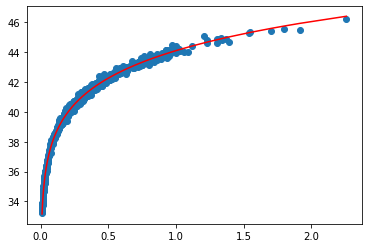

In [ ]:
print("Om0: " + str(best_vals[0]))
print("R0: " + str(best_vals[1]))
print("a: "+ str(best_vals[2]))

y_hat = final_eq(x, *best_vals)

print_data()
plt.plot(x, final_eq(x, *best_vals), 'r-', label='fit')

#Print R^2 value
r_sq = r_square(y, y_hat)
print("\nR-squared = " + str(r_sq))

#Print the chi-squared value
chi_sq = chisq(y, y_hat, sigma)
print("\nChi-squared = " + str(chi_sq))

#print reduced chi-squared, depends on above chisq calculation, do not need to modify unless size of y or numbers of Params changed
red_chisq = chi_sq / (y.size - len(best_vals))
print("\nReduced Chi-squared = " + str(red_chisq))

In [ ]:
out_py = y_hat
np.savetxt("out_py.csv", out_py, delimiter=",")

## Tool 2: Using LmFit

In [ ]:
model = Model(final_eq)
model.param_names, model.independent_vars
params = model.make_params(Om0=best_vals[0], R0=best_vals[1], a=best_vals[2])

Fit Report: 
[[Model]]
    Model(final_eq)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 1048
    # variables        = 3
    chi-square         = 21.3872616
    reduced chi-square = 0.02046628
    Akaike info crit   = -4072.65186
    Bayesian info crit = -4057.78794
[[Variables]]
    Om0:  0.73624290 +/- 0.08475618 (11.51%) (init = 0.6321311)
    R0:   3591.77935 +/- 195.825467 (5.45%) (init = 3339.339)
    a:    1.13301213 +/- 0.03995697 (3.53%) (init = 1.078716)
[[Correlations]] (unreported correlations are < 0.100)
    C(Om0, R0) =  0.997
    C(Om0, a)  =  0.837
    C(R0, a)   =  0.794


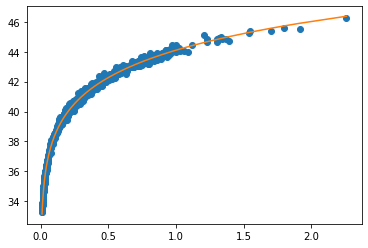

In [ ]:
result =model.fit(y, params, z=x)
print_data()
plt.plot(x, result.best_fit)
print("Fit Report: ")
print(result.fit_report())


# References:

1. https://www.physics.utoronto.ca/~phy224_324/web-pages/Lecture_Python_Data_Analysis_ProfClark.pdf 
2. http://phy224.ca/19-curvefit/index.html
3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html